# Deterministic optimisation

Here we optimise over several deterministic objective functions evaluated using the fluid flow model. 

* [This link](https://github.com/grahamburgess3/homeless_services/blob/main/notes/2024-02-19-Optim_Formulations_Specific/Optim-Formulations.pdf) gives the details of the suggested formulations.
* [This link](https://github.com/grahamburgess3/homeless_services/blob/main/08_fluid_flow_model.ipynb) details the workings of the fluid flow model.

The goal is to establish which features of a problem formulation best capture the aspects of the real-world problem we are interested in modeling. 

In [1]:
# imports
import deterministic_optimisation as do
import json

The data below is based upon the system as it has previously been modelled by Singham et al (2023). We have increased the arrival rate to ensure that the unsheltered Q never empties

In [2]:
# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [6000.0, 6000.0, 6000.0, 6000.0, 6000.0],
        'budget' : 200000000, # in dollars
        'costs_accomm' : {'housing' : 30000, 'shelter' : 10000}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'horizon' : 5, # modelling horizon AND decision horizon. E.g. we model 5 years into future, in each year we build X houses/shelters
                    'timestep' : 1/365, # in years
                    'model' : do.FluidModel}

####  $\Phi_0$
    # min TimeAvg(E[unsh(t)])
    # s.t. total budget constraint
    #      annual minimum build constraint

------- Optimal solution -------
Number of housing units to build annually: [500.0, 500.0, 500.0, 500.0, 500.0]
Number of shelter units to build annually: [10500.0, 500.0, 500.0, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 0%: 0.0 extra houses.
Proportion of surplus budget spent on shelter: 100%: 10000.0 extra shelters.
Optimal objective val: 6976.85


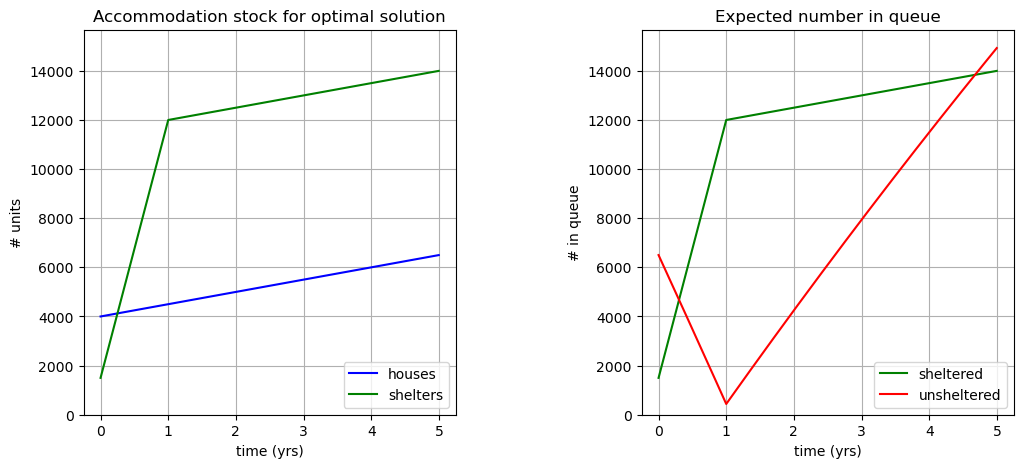

In [3]:
# Set up problem and solve
problem = do.Phi(data, modeling_options, 'phi0')
problem.add_total_budget_constraint()
problem.add_baseline_build_constraint()
problem.solve('glpk')
problem.print_results()
problem.plot_opt()

Here we see that for the given cost of shelter and given housing service rate, it is best to spend all of our surplus budget on shelter in the first year. This would immediately bring down the unsheltered queue. If we were to, say, increase the cost of shelter, our optimal solution would flip to to spend all of our surplus budget on housing in the first year. 

#### Understanding the charts
* The green lines on the left and right hand charts are equivalent: since we assume the unhseltered queue never vanishes, the size of the sheltered queue is always equal to the number of shelters, and that is related to the shelter build function in the optimal solution. 
* The blue line on the left hand side is related to the housing build function in the optimal solution.
* The red line on the right hand side (unsheltered queue) is affected by both the green and blue lines on the left. A steep green or blue line will contribute to a sharp decrease in the unsheltered queue as space is made available in housing/shelter to relieve the unsheltered queue. A large number of houses (blue line) will also lead to a greater flow out of the system and therefore contribute towards a gradual decrease in the unsheltered queue. 

####  $\Phi_1$
    # min TimeAvg(E[unsh(t) + c*E[sh(t)]])
    # s.t. total budget constraint
    #      annual minimum build constraint

------- Optimal solution -------
Number of housing units to build annually: [3833.33, 500.0, 500.0, 500.0, 500.0]
Number of shelter units to build annually: [500.0, 500.0, 500.0, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 100%: 3333.33 extra houses.
Proportion of surplus budget spent on shelter: 0%: 0.0 extra shelters.
Optimal objective val: 13343.6


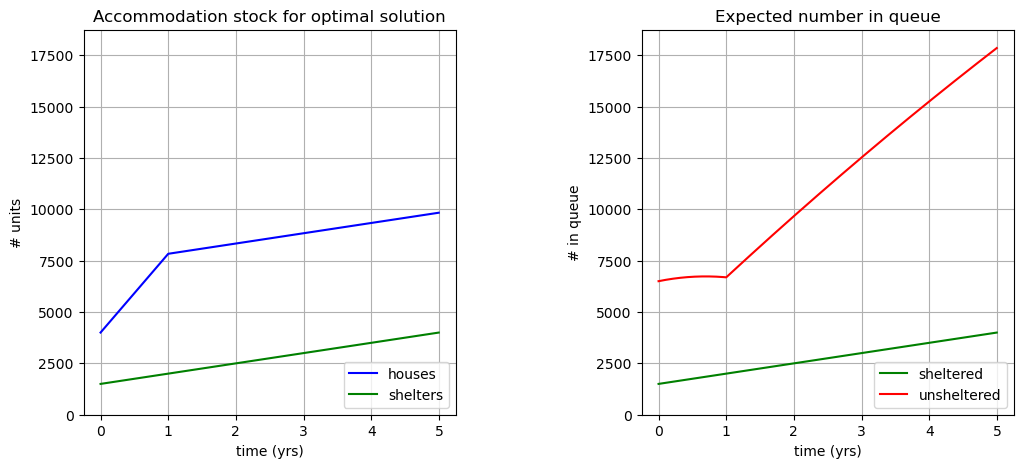

In [10]:
# Set up problem and solve
problem = do.Phi(data, modeling_options, 'phi1', c=0.75)
problem.add_total_budget_constraint()
problem.add_baseline_build_constraint()
problem.solve('glpk')
problem.print_results()
problem.plot_opt()

Here we see that by penalising the size of the sheltered queue, our preference shifts to spending all of our surplus budget on housing in the first year. 

####  $\Phi_2$
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint

------- Optimal solution -------
Number of housing units to build annually: [2737.06, 500.0, 500.0, 500.0, 500.0]
Number of shelter units to build annually: [3788.83, 500.0, 500.0, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 67%: 2237.06 extra houses.
Proportion of surplus budget spent on shelter: 33%: 3288.83 extra shelters.
Optimal objective val: 137765169.41


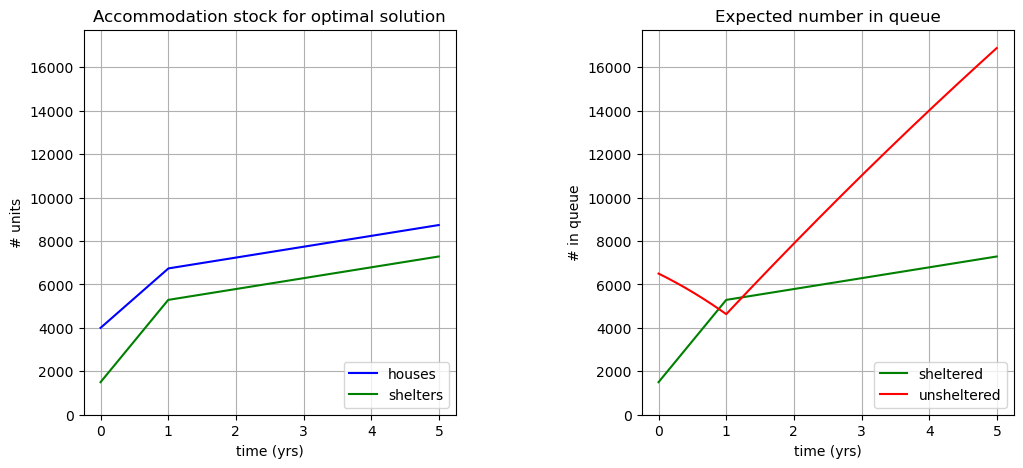

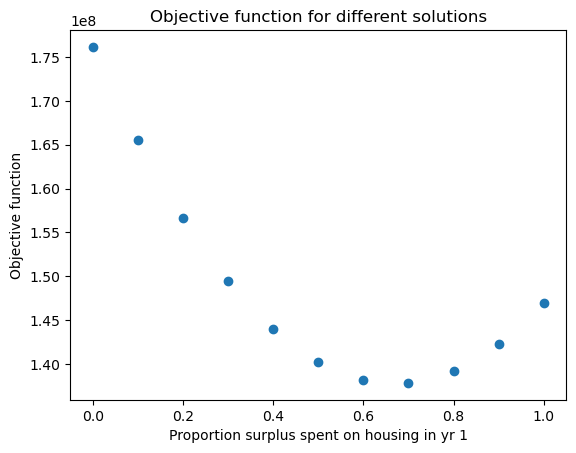

In [9]:
# Set up problem and solve
problem = do.Phi(data, modeling_options, 'phi2', c=0.75)
problem.add_total_budget_constraint()
problem.add_baseline_build_constraint()
problem.solve('ipopt')
problem.print_results()
problem.plot_opt()
problem.plot_obj_curve(10)

With quadratic terms in the objective function, an optimal solution is encouraged to let neither the sheltered nor the unsheltered queue get too large, by building a mixture of housing and shelter. Some experimentation (not illustrated above) with different values of $c$ shows that the optimal mix is sensitive to this choice of the weight placed on the squared sheltered queue. 

####  $\Phi_3$
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint
    #      shape constraint on house building: non-decreasing
    #      shape constraint on shelter building: non-decreasing and then non-increasing

------- Optimal solution -------
Number of housing units to build annually: [663.85, 663.85, 663.85, 663.85, 663.85]
Number of shelter units to build annually: [3014.07, 3014.07, 3014.07, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 25%: 819.26 extra houses.
Proportion of surplus budget spent on shelter: 75%: 7542.21 extra shelters.
Optimal objective val: 165509632.58


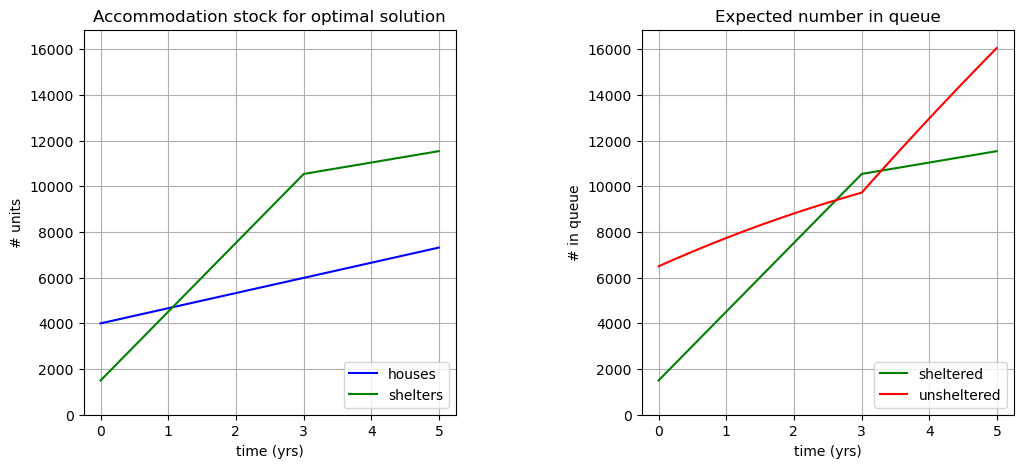

In [15]:
# Set up problem and solve
problem = do.Phi(data, modeling_options, 'phi2', c=0.75)
problem.add_total_budget_constraint()
problem.add_baseline_build_constraint()
problem.add_housing_increase()
problem.add_shelter_increase_decrease(shelter_mode = 3) # shelter build rate is non-decreasing up to and including the year given by shelter-mode, non-increasing thereafter. 
problem.solve('ipopt')
problem.print_results()
problem.plot_opt()

By forcing the # new houses to either stay the same or increase from year to year, we spread the house building out equally over the year. Earlier is still always better so there is no incentive here for the # new houses to increase. Building houses later reduces their positive impact on the objective function because it takes time for the system to see their benefit of increasing the flow out of the system. Therefore, compared to $\Phi_3$ with the same $c$ value, our optimal solution has a greater preference for extra shelters, whose benefit over housing (i.e. the fact that they are cheaper) is immediate since they simply take people out of the unshelter queue and into the sheltered queue. Again, earlier is still always better so there is no incentive to build anything above the baseline after the shelter mode. 

####  $\Phi_4$
    # min TimeAvg(E[unsh(t)^2]) + WeightedTimeAvg(E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint
    #      shape constraint on house building: increasing
    #      shape constraint on shelter building: increasing and then decreasing

Here we work with a weight function $w(t)$ which is linear and non-decreasing w.r.t time. We require the $w(t)$ function to reach a maximum of $\frac{1}{horizon}$ since this is the constant weight by which we penalise the squared unsheltered queue. Therefore the gradient of $w(t)$ has a lower bound of $0$ and upper bound of $\frac{1}{horizon^2}$. Our choice of $m$ below must take a value between $0$ and $1$ and indicates the magnitude of the gradient of $w(t)$, $0$ being no gradient, $1$ being max possible gradient. 

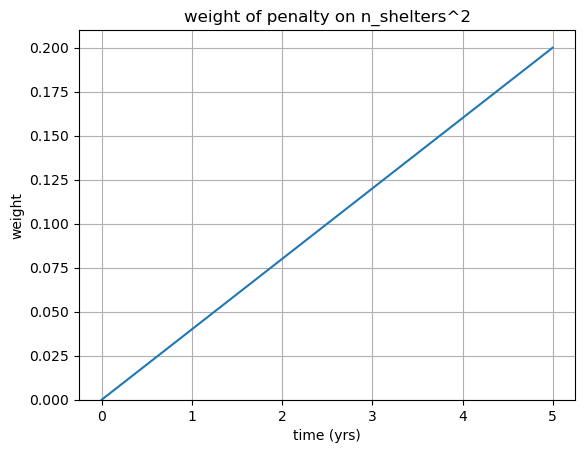

In [7]:
m = 1.0
weights = do.get_linear_weight_func(m, modeling_options['horizon'], modeling_options['timestep'])
do.plot_weight_func(weights, modeling_options['horizon'], modeling_options['timestep'])

------- Optimal solution -------
Number of housing units to build annually: [617.1, 617.1, 617.1, 617.1, 617.1]
Number of shelter units to build annually: [3247.84, 3247.84, 3247.84, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 18%: 585.49 extra houses.
Proportion of surplus budget spent on shelter: 82%: 8243.52 extra shelters.
Optimal objective val: 159546029.65


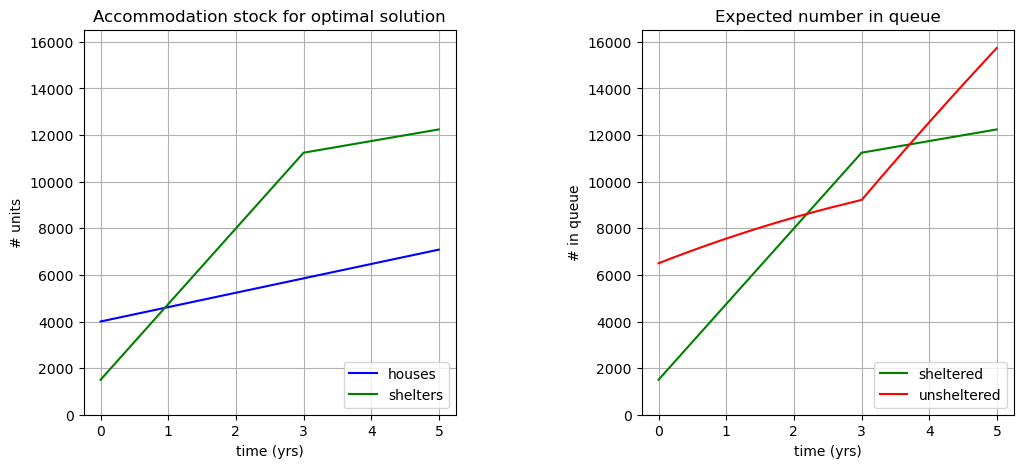

In [8]:
# Set up problem and solve
problem = do.Phi(data, modeling_options, 'phi4', c=weights)
problem.add_total_budget_constraint()
problem.add_baseline_build_constraint()
problem.add_housing_increase()
problem.add_shelter_increase_decrease(shelter_mode = 3) # shelter build rate is non-decreasing up to and including the year given by shelter-mode, non-increasing thereafter. 
problem.solve('ipopt')
problem.print_results()
problem.plot_opt()

Here the penalty for shelters increases towards the end of the modelled horizon until it is the same as the penalty for the unsheltered population. The optimal solution is still a mix of housing and shelter (due to the quadratic terms in the objective function). 

####  $\Phi_5$
    # min TimeAvg(E[unsh(t)^2]) + WeightedTimeAvg(E[sh(t)^2])
    # s.t. annual increasing budget constraint

Here we introduce an annual budget constraint which increases over time, in place of a total budget constraint. We drop shape constraints and annual minimum build constraints - the quadratic objective function remains to ensure no one queue gets too large, but the weighting of the penalty on the squared shelterd queue is again time dependent. 

------- Optimal solution -------
Number of housing units to build annually: [0.0, 0.0, 0.0, 1517.58, 1771.08]
Number of shelter units to build annually: [2000.0, 3000.0, 4000.0, 447.26, 686.76]
Proportion of annual budget spent on housing: ['0%', '0%', '0%', '91%', '89%']
Proportion of annual budget spent on shelter: ['100%', '100%', '100%', '9%', '11%']
Optimal objective val: 204954314.87


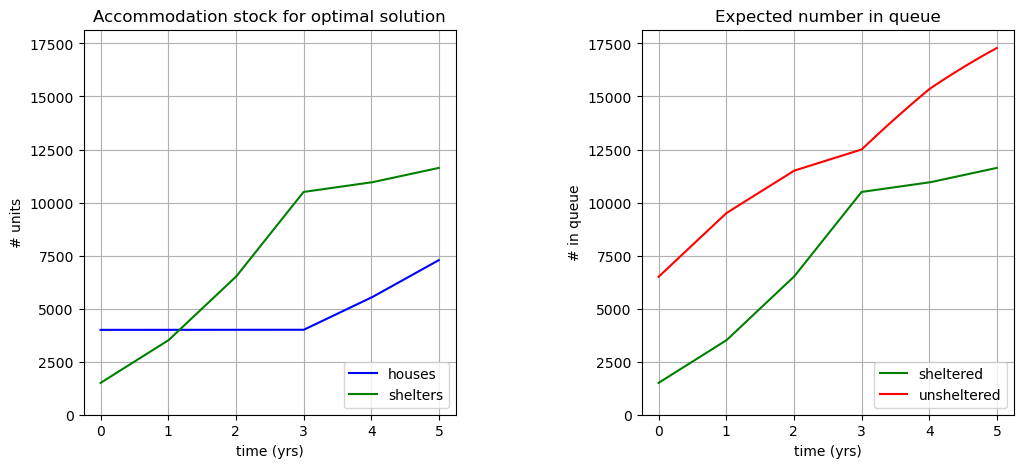

In [9]:
# Set up problem and solve
problem = do.Phi(data, modeling_options, 'phi4', c=weights)
problem.add_annual_budget_constraint([0.1, 0.15, 0.2, 0.25, 0.3]) # proportions must add to 1. 
problem.solve('ipopt')
problem.print_results_phi5()
problem.plot_opt()

Here we see that in the early years, with a small penalty on shelter, shelter is preferred to reduce the unsheltered queue quickly as much as possible. However in later years, as the penalty on the sheltered queue approaches that of the unsheltered queue, it is prefereable to use extra housing to increase the overall throughput of the system. 

#### Comments
* We could consider different weight functions
* We could consider modelling beyond the 5 year decision horizon, this would mean a fuller effect of building housing would be realised (especially towards the end of the decision horizon)j
* We could use the analytical queueing model to allow steady-state solutions. 

#### Using the analytical queueing model

##### Changes to the M(t)/M/H(t) queueing model

Here $H(t)$ refers to the number of houses over time. We have changed this $H(t)$ function in order to make it more appropriate for this analysis. 

Previously, $H(t)$ reflected the fact that every 2 months, an integer number of houses were built, and that bi-monthly build rate was constant within each year, but could change from year to year. Therefore, an annual build rate had to be a multiple of six and if it wasn't, the build rate was rounded down to the nearest six. The same was the case for the build rate for shelters. This is not suitable for this deterministic optimisation since for continuous-valued build functions, subsets of solutions will have the same objective value, which is not suitable for a solver which uses some gradient information. 

We now construct $H(t)$ so that at at any time $t$, based on continuous-valued annual build rates, we calculate the number of whole houses ready for use at time $t$, and that dictates the total service rate until time $t + \Delta t$. For example, if we start with 20 houses and the annual house build rate is 40/year, then at time t = 60 days, we have $h(t=60) = \lfloor 20 + \frac{40}{365} * 60 \rfloor = 26$. We do the same for the number of shelters $s(t)$ at any time $t$. 

This brings the queueing model further away from the simulation model, and more in line with the fluid model. However, it is not quite the same as the fluid model, since in the fluid model, a fraction of a house can contribute to an increased service rate. 

The response $y(\boldsymbol{h},\boldsymbol{s})$ where $\boldsymbol{h},\boldsymbol{s}$ are the house and shelter annual build rates, respectively, using this amended queueing model will still be a step function, since an infinitessimally small change to the build rate functions will leave the number of houses and shelters, $H(t)$ and $S(t) \hspace{0.2cm} \forall t \in \{1, 1 + \Delta t, ... , T\}$ unchanged. It therefore remains to be seen whether this setup is suitable for the deterministic optimisation formulation. 

**NOTE**: it  does not make sense to allow $H(t)$ and $S(t)$ to take non-integer values for time $t \in \{1, 1 + \Delta t, ... , T\}$, because our state space $n \in \{1, 2, ..., N\}$ where $n$ is the number of people in the system, takes integer values. 

##### Applying the ammended queueing model to the deterministic optimisation in Pyomo. 

Currently, this has been unsuccessful, when using the GLPK and IPOPT solvers. This is because in the numerical integration, maxima and minima are used involving the number of houses/shelters at a given time, which is not acceptable for these solvers. For example, the size of the unsheltered queue $\text{unsh}(t)$ at time $t$ is given by $\text{unsh}(t) = max(0,n(t) - H(t) - S(t))$. A next step is to establish whether:

* there is a way around this with GLPK or IPOPT
* there are other suitable solvers for this problem. 